In [3]:
#Imports
from rdkit.Chem import PandasTools
from rdkit import Chem
import pandas as pd
import pickle

#Functions
def import_sdf(sdf):
    """Import an sdf file and return a Dataframe with an additional Smiles column."""

    df = PandasTools.LoadSDF(sdf)
    df["smiles"] = [Chem.MolToSmiles(m) for m in df["ROMol"]]
    return df

def create_conjugate(mol, id, pka, pH=7.4):
    """Create a new molecule that is the conjugated base/acid to the input molecule."""
    mol = Chem.RWMol(mol)
    atom = mol.GetAtomWithIdx(id)
    charge = atom.GetFormalCharge()
    Ex_Hs = atom.GetNumExplicitHs()
    Tot_Hs = atom.GetTotalNumHs()

    #
    if pka > pH and Tot_Hs > 0:
        atom.SetFormalCharge(charge - 1)
        if Ex_Hs > 0:
            atom.SetNumExplicitHs(Ex_Hs - 1)
    elif pka < pH:
        atom.SetFormalCharge(charge + 1)
        if Tot_Hs == 0 or Ex_Hs > 0:
            atom.SetNumExplicitHs(Ex_Hs + 1)
    else:
        # pka > pH and Tot_Hs < 0
        atom.SetFormalCharge(charge + 1)
        if Tot_Hs == 0 or Ex_Hs > 0:
            atom.SetNumExplicitHs(Ex_Hs + 1)

    atom.UpdatePropertyCache()
    return mol

def conjugates_to_dataframe(df: pd.DataFrame):
    """Take DataFrame and return a DataFrame with a column of calculated conjugated molecules."""
    conjugates = []
    for i in range(len(df.index)):
        mol = df.ROMol[i]
        index = int(df.marvin_atom[i])
        pKa_type = df.marvin_pKa_type[i]
        pka = float(df.marvin_pKa[i])
        conjugates.append(create_conjugate(mol, index, pka))
    df["Conjugates"] = conjugates
    return df


def sort_conjugates(df):
    """Take DataFrame, check and correct the protonated and deprotonated molecules columns and return the new Dataframe."""
    prot = []
    deprot = []
    for i in range(len(df.index)):
        indx = int(df.marvin_atom[i])
        mol = df.ROMol[i]
        conj = df.Conjugates[i]

        charge_mol = int(mol.GetAtomWithIdx(indx).GetFormalCharge())
        charge_conj = int(conj.GetAtomWithIdx(indx).GetFormalCharge())

        if charge_mol < charge_conj:
            prot.append(conj)
            deprot.append(mol)
        elif charge_mol > charge_conj:
            prot.append(mol)
            deprot.append(conj)
    df["protonated"] = prot
    df["deprotonated"] = deprot
    df = df.drop(columns=["ROMol", "Conjugates"])
    return df

#Run Function

def preprocess(name, sdf):
    """Take name string and sdf path, process to Dataframe and save it as a pickle file."""
    df = import_sdf(sdf)
    df = conjugates_to_dataframe(df)
    df = sort_conjugates(df)
    with open(f'processed/pd_{name}.pkl', 'wb') as pickle_file:
        pickle.dump(df,pickle_file)
        
def preprocess_all(datasets, title='pd_all_datasets'):
    """Take dict of sdf paths, process to Dataframes and save it as a pickle file."""
    pd_datasets = {}
    directory = 'data/pandas_df'
    for name, path in datasets.items(): 
        df = import_sdf(path)
        df = conjugates_to_dataframe(df)
        df = sort_conjugates(df)
        pd_datasets[name]=df        
    with open(f'{directory}/{title}.pkl', 'wb') as pickle_file:
        pickle.dump(pd_datasets,pickle_file)


In [4]:
#Data files
path = "../../data/Baltruschat/"
sdf_training = "combined_training_datasets_unique.sdf"
sdf_novartis = "novartis_cleaned_mono_unique_notraindata.sdf"
sdf_AvLiLuMoVe = "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

datasets = {
    "Training": path+sdf_training,
    "Novartis": path+sdf_novartis,
    "AvLiLuMoVe": path+sdf_AvLiLuMoVe,
}

preprocess_all(datasets, title='pd_all_datasets')

# for key, value in datasets.items():
#     preprocess(key, value)

,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated
0,6.21,6.09,10,basic,['chembl25'],1702768,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,,
1,7.46,8.2,9,basic,['chembl25'],273537,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,,
2,4.2,3.94,9,basic,['datawarrior'],7175,Brc1cc2cccnc2c2ncccc12,,
3,3.73,5.91,8,acidic,['datawarrior'],998,Brc1ccc(-c2nn[n-]n2)cc1,,
4,11.0,8.94,13,basic,['chembl25'],560562,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,,
...,...,...,...,...,...,...,...,...,...
5989,4.4,3.56,1,basic,['datawarrior'],5933,c1nc(NC2CCCCC2)c2ncn(C3CCCCC3)c2n1,,
5990,6.23,5.88,13,basic,['datawarrior'],5897,c1nc2c(ccc3c4c(cnc32)CCCC4)c2c1CCCC2,,
5991,5.98,6.35,8,basic,['datawarrior'],3731,c1nc2cc3c(cc2[nH]1)CCCC3,,
5992,6.63,5.42,5,basic,['datawarrior'],1962,c1ncc2c(n1)NCCN2,,

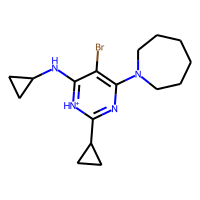
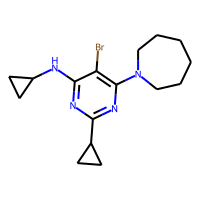
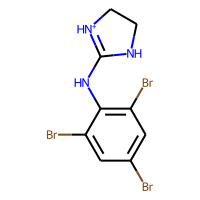
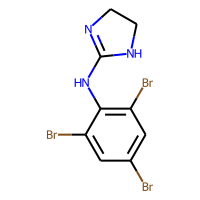
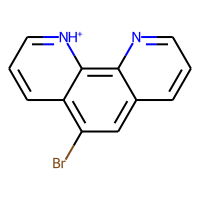
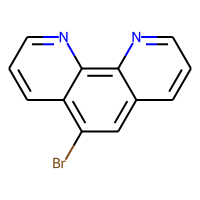
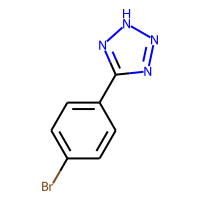
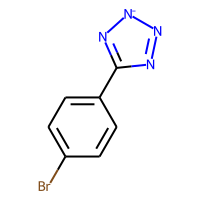
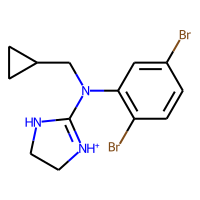
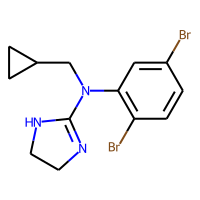
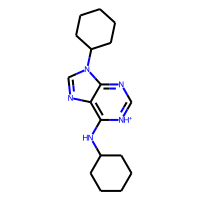
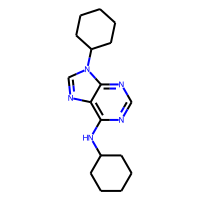
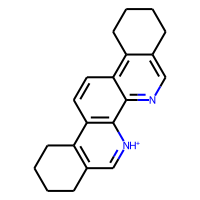
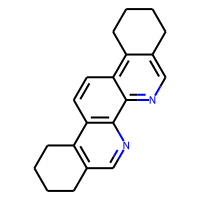
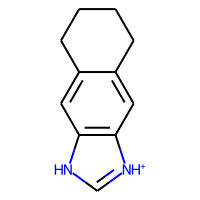
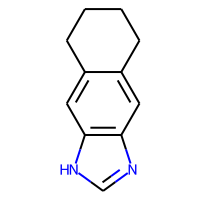
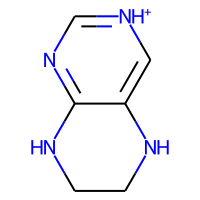
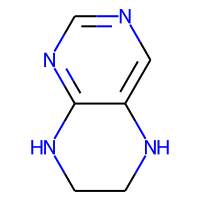
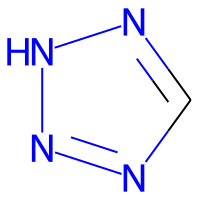
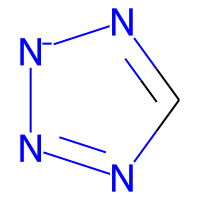

In [5]:
with open('data/pandas_df/pd_all_datasets.pkl', 'rb') as pickle_file:
    pd_dict = pickle.load(pickle_file)
next(iter(pd_dict.values()))

In [4]:
# with open('processed/pd_Novartis.pkl', 'rb') as pickle_file:
#     df2 = pickle.load(pickle_file)
# df2